In [1]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from imutils import paths
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
DATA_PATH = '/content/drive/MyDrive/face-mask-detector-master/dataset/'

In [5]:
# 讀取dataset圖像列表，進行資料分類和初始化
imagePaths = list(paths.list_images(DATA_PATH))
data = []
labels = []

In [6]:
# loop over the image paths
for imagePath in imagePaths:
    # 從filename中提取class label
    label = imagePath.split(os.path.sep)[-2]
    # 載入圖像並對其進行預處理
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # 更新data和labels lists
    data.append(image)
    labels.append(label)

In [7]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
# 使用75％的data進行訓練，剩餘25%的data劃分為training和testing
(trainX, testX, trainY, testY) = train_test_split(
    data, 
    labels, 
    test_size=0.20, 
    stratify=labels, 
    random_state=42
)

In [9]:
# 增強圖像訓練
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [10]:
# 載入MobileNetV2 network，保留FC layer
baseModel = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers並且在第一次訓練中不被更新
for layer in baseModel.layers:
    layer.trainable = False
# compile model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

Epoch 1/20
35/35 [==============================] - 22s 376ms/step - loss: 0.7839 - accuracy: 0.5914 - val_loss: 0.2248 - val_accuracy: 0.9893
Epoch 2/20
35/35 [==============================] - 12s 338ms/step - loss: 0.2583 - accuracy: 0.9441 - val_loss: 0.0949 - val_accuracy: 1.0000
Epoch 3/20
35/35 [==============================] - 12s 336ms/step - loss: 0.1484 - accuracy: 0.9751 - val_loss: 0.0537 - val_accuracy: 1.0000
Epoch 4/20
35/35 [==============================] - 12s 336ms/step - loss: 0.0926 - accuracy: 0.9831 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch 5/20
35/35 [==============================] - 12s 341ms/step - loss: 0.0787 - accuracy: 0.9861 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 6/20
35/35 [==============================] - 12s 334ms/step - loss: 0.0534 - accuracy: 0.9926 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 7/20
35/35 [==============================] - 12s 337ms/step - loss: 0.0463 - accuracy: 0.9963 - val_loss: 0.0157 - val_accuracy: 1.0000

In [14]:
# 預測testing set
predIdxs = model.predict(testX, batch_size=BS)
# 對每個testing set圖像，找到具有最大預測機率的labels
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       141
without_mask       1.00      1.00      1.00       140

    accuracy                           1.00       281
   macro avg       1.00      1.00      1.00       281
weighted avg       1.00      1.00      1.00       281



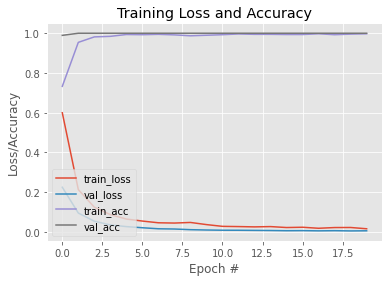

In [15]:
# 畫出training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [16]:
# save model
model.save('/content/drive/MyDrive/face-mask-detector-master/models/model.h5', save_format="h5")

In [17]:
MODEL_PATH = '/content/drive/MyDrive/face-mask-detector-master/models/'
prototxtPath = os.path.sep.join([MODEL_PATH, 'deploy.prototxt'])
weightsPath = os.path.sep.join([MODEL_PATH, 'res10_300x300_ssd_iter_140000.caffemodel'])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model('/content/drive/MyDrive/face-mask-detector-master/models/model.h5')

In [18]:
def load_image(img_path):
    image = imread(img_path)
    (h, w) = image.shape[:2]
    return image, h, w

In [19]:
def blob_from_image(image_file):
    blob = cv2.dnn.blobFromImage(image_file, 1.0, (300, 300), (104.0, 177.0, 123.0))
    return blob

In [20]:
def prediction_preparation(blob):
    net.setInput(blob)
    detections = net.forward()
    return detections

In [21]:
def predict(detections, image, h, w):

    # loop over the detections
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # 獲取face ROI，將BGR轉換成RGB，對其調整224x224後，進行預處理
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # 透過model判斷臉部是否有mask
            (mask, withoutMask) = model.predict(face)[0]
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (255, 0, 0)

            # 在label中包含機率
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # 在影像輸出label和frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    return image

In [22]:
def predict_it(image_path):
    image, h,w = load_image(img_path=image_path)
    blob = blob_from_image(image_file=image)
    detections = prediction_preparation(blob=blob)
    image = predict(detections=detections, image=image, h=h, w=w)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

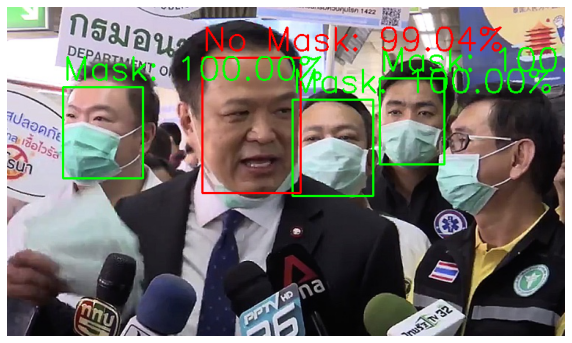

In [23]:
predict_it(image_path='/content/drive/MyDrive/face-mask-detector-master/examples/test_face_mask.jpg')